# 라즈베리파이기반 딥러닝 주행(Deep Learning Driving)
@2020-06-22/@pletalk

주행데이타만으로 모델 학습하기

* 문서이력
    * 2020-06-22 데이타변형없이 주행데이타만으로 학습
    * 2020-06-14 재검증(OK)
    * 2020-05-24 코드추가하기(이미지로딩, 추가, 학습등)
    * 2020-05-23 처음작성

* [참고자료]
    * [참조 소스코드(DeepPiCar)](https://github.com/dctian/DeepPiCar/blob/master/models/lane_navigation/code/end_to_end_lane_navigation.ipynb)
    * [DeepPiCar — Part 5: Autonomous Lane Navigation via Deep Learning](https://towardsdatascience.com/deeppicar-part-5-lane-following-via-deep-learning-d93acdce6110)

<img src="https://miro.medium.com/max/1374/1*p8JiHcvH-wpSxcCzz2r1Sw.jpeg"/>

## [1] DeepPiCar Git코드 다운로드
* 기본 다운로드 디렉토리는 /content/DeepPiCar 디렉토리에 저장

In [1]:
! git clone https://github.com/dctian/DeepPiCar.git

Cloning into 'DeepPiCar'...
remote: Enumerating objects: 1027, done.
remote: Total 1027 (delta 0), reused 0 (delta 0), pack-reused 1027
Receiving objects: 100% (1027/1027), 141.14 MiB | 11.79 MiB/s, done.
Resolving deltas: 100% (320/320), done.


In [2]:
! pwd
! cd DeepPiCar

/content


## [2] 라이브러리 로딩하기

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import logging
import math

import os
import random
import fnmatch
import datetime
import pickle

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

# tensorflow
import tensorflow as tf
import keras
from keras.models import Sequential  # V2 is tensorflow.keras.xxxx, V1 is keras.xxx
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.models import load_model
print( f'tf.__version__: {tf.__version__}' )
print( f'keras.__version__: {keras.__version__}' )

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
from imgaug import augmenters as img_aug
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image

Using TensorFlow backend.


tf.__version__: 2.2.0
keras.__version__: 2.3.1


## [3] OpenCV기반 주행선탐지를 위한 이미지 가져오기
    * directory에 주행을 캡쳐한 이미지들이 있음
    * 로딩을 위한 코드 작성

### 1> 학습할 동영상의 프레임별 이미지 파일 로딩하기

In [4]:
# 데이타를 가져올 디렉토리 설정하기
# 확장자 *.png를 가지는 파일들을 확인할 것
# 파일명의 포맷 -> 이름_순서_각도.png
data_dir = '/content/DeepPiCar/models/lane_navigation/data/images'

### 2> 이미지저장 디렉토리에서 이미지파일 파일 읽어서 분류하기 (경로, 각도)

In [5]:
file_list = os.listdir(data_dir)
image_paths = []
steering_angles = []
pattern = "*.png"
for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(data_dir,filename))
        angle = int(filename[-7:-4])  # 092 part of video01_143_092.png is the angle. 90 is go straight
        steering_angles.append(angle)

### 3> 파일경로와 각도 리스트 확인하기

In [6]:
image_paths[0:3]

['/content/DeepPiCar/models/lane_navigation/data/images/video01_045_057.png',
 '/content/DeepPiCar/models/lane_navigation/data/images/video01_104_086.png',
 '/content/DeepPiCar/models/lane_navigation/data/images/video01_036_053.png']

In [7]:
steering_angles[0:3]

[57, 86, 53]

In [8]:
df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Angle'] = steering_angles

(array([1.0000, 1.0000, 8.0000, 4.0000, 5.0000, 11.0000, 6.0000, 7.0000,
        26.0000, 2.0000, 10.0000, 21.0000, 18.0000, 23.0000, 15.0000,
        21.0000, 12.0000, 10.0000, 2.0000, 5.0000, 2.0000, 1.0000, 3.0000,
        2.0000, 3.0000]),
 array([44.0000, 46.3600, 48.7200, 51.0800, 53.4400, 55.8000, 58.1600,
        60.5200, 62.8800, 65.2400, 67.6000, 69.9600, 72.3200, 74.6800,
        77.0400, 79.4000, 81.7600, 84.1200, 86.4800, 88.8400, 91.2000,
        93.5600, 95.9200, 98.2800, 100.6400, 103.0000]),
 <a list of 25 Patch objects>)

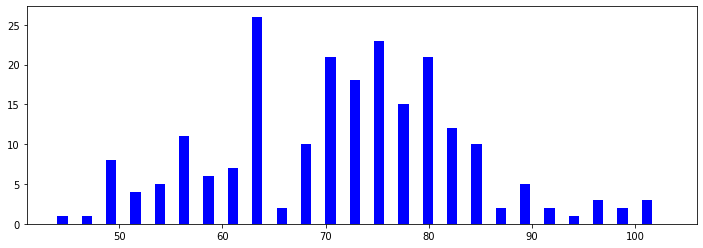

In [9]:
# 주행각도에 대한 분포
num_of_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(df['Angle'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(df['Angle'], bins=num_of_bins, width=1, color='blue')

## [4] 학습데이타와 테스트 데이타 나누기

### 1> train_test_split()를 활용하여 나누기 (비율기반)

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split( image_paths, steering_angles, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

Training data: 175
Validation data: 44


Text(0.5, 1.0, 'Validation Data')

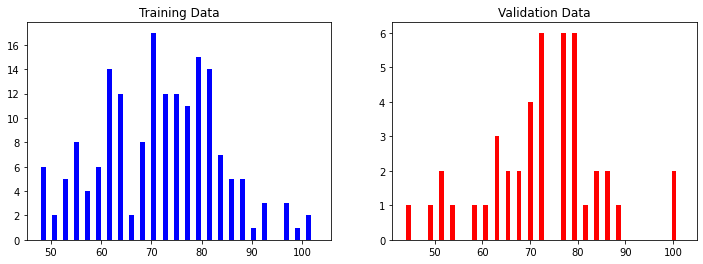

In [11]:
# plot the distributions of train and valid, make sure they are consistent
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color='blue')
axes[0].set_title('Training Data')
axes[1].hist(y_valid, bins=num_of_bins, width=1, color='red')
axes[1].set_title('Validation Data')

## [5] 이미지 로딩 및 처리 함수들

### 1> 이미지 출력하기

In [13]:
def show_image(image):
    plt.figure(figsize=(8,6))
    plt.imshow(image)

def show_compare_images(src_image, tgt_image):
    nrow=1
    ncol=2
    fig, axes = plt.subplots(nrow, ncol, figsize=(12, 6))
    fig.tight_layout()
    axes[0].imshow(src_image)
    axes[1].imshow(tgt_image)

### 2> 이미지 로딩하기

In [14]:
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

### 3> 이미지 로딩 및 출력 테스팅

origin_image_file= /content/DeepPiCar/models/lane_navigation/data/images/video01_098_088.png
origin_steering_angle= 88


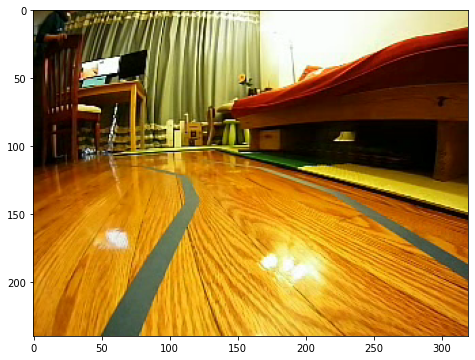

In [40]:
test_sample_index = 0

rgb_image = load_image(X_train[test_sample_index])
steering_angle = y_train[test_sample_index]
print("origin_image_file=",X_train[test_sample_index])
print("origin_steering_angle=",steering_angle)
show_image(rgb_image)

In [49]:
rgb_image.shape

(240, 320, 3)

## [6] 이미지 전처리하기(preprocessing)
* NVIDIA모델의 입력 크기로 변경

### 1> 이미지 전처의 단계별 수행과정 이해
* 이미지의 크기 변경 (높이를 1/2로 변경)

In [19]:
# 이미지의 rgb 차원의 slice값으로 이미지 크기를 변경
height, _, _ = rgb_image.shape
resized_rgb_image = rgb_image[int(height/2):,:,:] 

In [20]:
rgb_image.shape

(240, 320, 3)

In [21]:
resized_rgb_image.shape

(120, 320, 3)

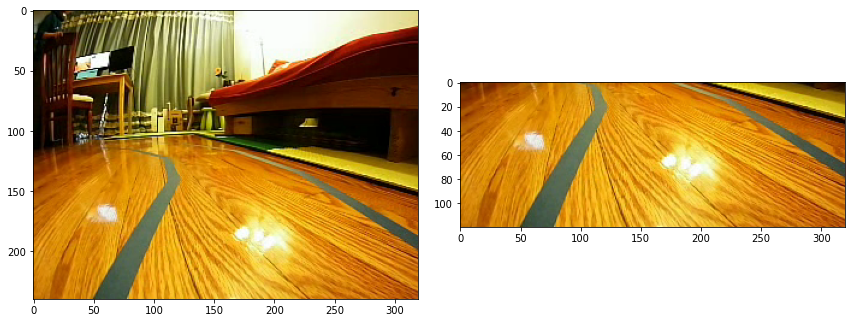

In [22]:
show_compare_images(rgb_image, resized_rgb_image)

### 2> 이미지의 형식변경 (RGB -> YUV)

In [23]:
resized_yuv_image = cv2.cvtColor(resized_rgb_image, cv2.COLOR_RGB2YUV)

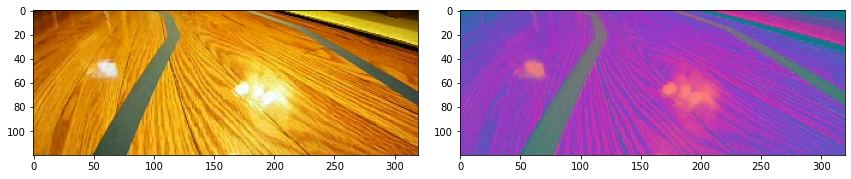

In [24]:
show_compare_images(resized_rgb_image, resized_yuv_image)

### 3> 가우시언블러링 처리(kernel size= 3)

In [25]:
resized_yuv_blurred_image = cv2.GaussianBlur(resized_yuv_image, (3,3), 0)

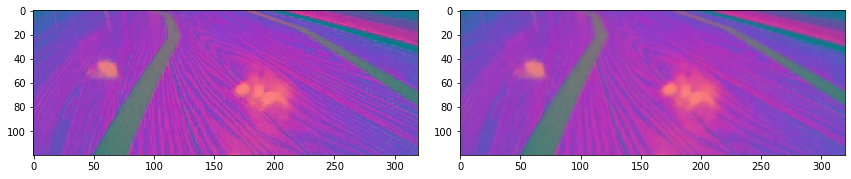

In [26]:
show_compare_images(resized_yuv_image, resized_yuv_blurred_image)

### 4> 이미지 크기 변경 (340x320 -> 66x200)

In [27]:
nvidia_input_image = cv2.resize(resized_yuv_blurred_image, (200,66))

In [28]:
nvidia_input_image.shape

(66, 200, 3)

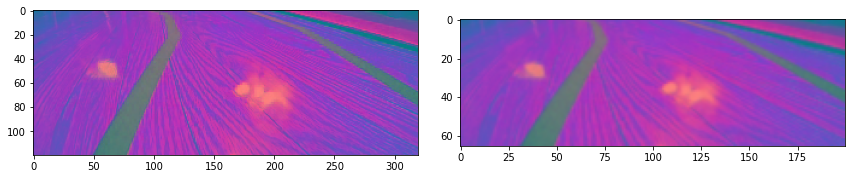

In [29]:
show_compare_images(resized_yuv_image, nvidia_input_image)

### 5> 위의 처리과정의 통합 함수 (img_preprocess)

In [30]:
# 1) 이미지의 포맷을 RGB2YUV로 변경
# 2) GuassianBlur처리를 수행
# 3) 프레임이미지 크기 변경 : 240x320 ->66x200

def img_preprocess(image):
    height, _, _ = image.shape
    image = image[int(height/2):,:,:]  
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  
    image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (200,66)) 
    image = image / 255 
    return image

In [31]:
prep_image = img_preprocess(rgb_image)

In [32]:
prep_image.shape

(66, 200, 3)

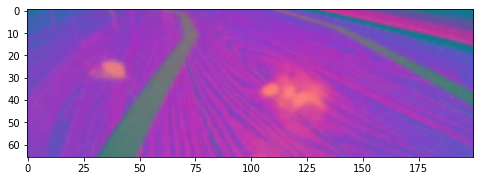

In [33]:
show_image(prep_image)

## [7] NVIDIA 모델 정의하기

### 1> NVIDIA Deep Learning 모델 정의하기

In [34]:
def nvidia_model():
    model = Sequential(name='Nvidia_Model')
    
    # elu=Expenential Linear Unit, similar to leaky Relu
    # skipping 1st hiddel layer (nomralization layer), as we have normalized the data
    
    # Convolution Layers
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu')) 
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    
    # output layer: turn angle (from 45-135, 90 is straight, <90 turn left, >90 turn right)
    model.add(Dense(1)) 
    
    # since this is a regression problem not classification problem,
    # we use MSE (Mean Squared Error) as loss function
    optimizer = Adam(lr=1e-3) # lr is learning rate
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

### 2> 모델생성하기 

In [35]:
model = nvidia_model()
print(model.summary())
# check at we will have 252,219 trainable parameters

Model: "Nvidia_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 20, 64)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

## [8] NVIDIA 주행 모델 학습하기 

### 1> Tensorboard 설정하기

In [36]:
model_output_dir = '/content/DeepPiCar/models/lane_navigation'
! mkdir '/content/DeepPiCar/models/lane_navigation/logs'

In [37]:
# tensorflow의 수행 로그 저장 디렉토리 설정하기
log_dir_root = f'{model_output_dir}/logs/'
log_dir_root

'/content/DeepPiCar/models/lane_navigation/logs/'

### 2> 학습 및 테스트 데이타 만들기

In [65]:
#
# 학습/테스트 이미지 파일명의 리스트를 입력 받아서 numpy.array()로 변환
#

def merge_images(filepath_list):
    merge_list = []
    for fname in filepath_list:
        # 원래 이미지를 로딩
        trgb_image = load_image(fname)

        # 전처리를 수행
        prep_trgb_image = img_preprocess(trgb_image)
        merge_list.append(prep_trgb_image)
    return np.array(merge_list)

In [63]:
tX_train = merge_images(X_train)
tX_train.shape

(175, 66, 200, 3)

In [64]:
tX_valid = merge_images(X_valid)
tX_valid.shape

(44, 66, 200, 3)

### 3> NVIDIA주행 학습하기

* Keara모델 기반의 CNN학습과 동일하게 진행

In [93]:
batch_size = 8
epochs = 100

In [94]:
history = model.fit(tX_train,y_train,
                    batch_size = batch_size,
                    epochs=epochs,
                    validation_data=(tX_valid, y_valid),
                    verbose=1)

Train on 175 samples, validate on 44 samples
Epoch 1/100
175/175 [==============================] - 0s 2ms/step - loss: 0.5130 - val_loss: 10.9811
Epoch 2/100
175/175 [==============================] - 0s 2ms/step - loss: 0.5570 - val_loss: 9.4814
Epoch 3/100
175/175 [==============================] - 0s 2ms/step - loss: 0.6725 - val_loss: 11.8393
Epoch 4/100
175/175 [==============================] - 0s 2ms/step - loss: 1.7237 - val_loss: 10.8849
Epoch 5/100
175/175 [==============================] - 0s 2ms/step - loss: 2.7141 - val_loss: 12.4327
Epoch 6/100
175/175 [==============================] - 0s 2ms/step - loss: 4.9673 - val_loss: 28.4134
Epoch 7/100
175/175 [==============================] - 0s 2ms/step - loss: 1402.2425 - val_loss: 89.2575
Epoch 8/100
175/175 [==============================] - 0s 2ms/step - loss: 605.6245 - val_loss: 375.8503
Epoch 9/100
175/175 [==============================] - 0s 2ms/step - loss: 306.4244 - val_loss: 318.1186
Epoch 10/100
175/175 [=======

### 3> 학습모델 저장하기

In [103]:
# epoch를 반복하면서 저장된 모델값은 _check.h5로 저장 
# 최종적인 학습모델의 값을 저장 

model.save(os.path.join(model_output_dir,'std_lane_navigation_final.h5'))

In [106]:
print("model_output_dir=",model_output_dir)

model_output_dir= /content/DeepPiCar/models/lane_navigation


## [10] 검증하기(validation)

### 1> 학습 및 검증오류 확인하기(그래프)

In [97]:
history.history

{'loss': [0.5130379445212228,
  0.5569760855606624,
  0.6724766983304705,
  1.7237134892599923,
  2.714117502485003,
  4.967262648173741,
  1402.2425438363211,
  605.6244655936105,
  306.42442626953124,
  180.36635070800781,
  137.73013266427176,
  144.31155997140067,
  143.34676208496094,
  139.06636692592076,
  139.58976213727678,
  134.3258387538365,
  146.85074266706195,
  158.790398210798,
  115.57263715471541,
  134.57108023507254,
  116.57263157435825,
  120.24924159458705,
  106.6457100568499,
  110.21400198800224,
  114.8319231741769,
  106.23277090890068,
  106.59276676722935,
  90.63471793038505,
  92.41366507393973,
  90.77965044294085,
  71.32221854073661,
  68.80112688337053,
  68.85704559326172,
  67.6464007786342,
  61.676456255231585,
  62.75495339529855,
  66.33404185703823,
  70.89932926722935,
  52.189676099504744,
  63.591042916434155,
  48.917932543073384,
  54.903028019496375,
  57.34954639979771,
  63.59452377319336,
  49.08098604474749,
  41.03501323154995,
  4

In [98]:
# 학습데이타의 손실/epoch
history.history['loss']

[0.5130379445212228,
 0.5569760855606624,
 0.6724766983304705,
 1.7237134892599923,
 2.714117502485003,
 4.967262648173741,
 1402.2425438363211,
 605.6244655936105,
 306.42442626953124,
 180.36635070800781,
 137.73013266427176,
 144.31155997140067,
 143.34676208496094,
 139.06636692592076,
 139.58976213727678,
 134.3258387538365,
 146.85074266706195,
 158.790398210798,
 115.57263715471541,
 134.57108023507254,
 116.57263157435825,
 120.24924159458705,
 106.6457100568499,
 110.21400198800224,
 114.8319231741769,
 106.23277090890068,
 106.59276676722935,
 90.63471793038505,
 92.41366507393973,
 90.77965044294085,
 71.32221854073661,
 68.80112688337053,
 68.85704559326172,
 67.6464007786342,
 61.676456255231585,
 62.75495339529855,
 66.33404185703823,
 70.89932926722935,
 52.189676099504744,
 63.591042916434155,
 48.917932543073384,
 54.903028019496375,
 57.34954639979771,
 63.59452377319336,
 49.08098604474749,
 41.03501323154995,
 42.77294322422573,
 42.780407017299105,
 43.605644792829

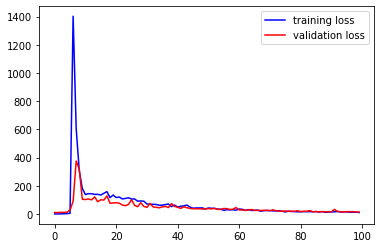

In [95]:
plt.plot(history.history['loss'],color='blue')
plt.plot(history.history['val_loss'],color='red')
plt.legend(["training loss", "validation loss"])

### 2> 학습모델 로딩 및 검증결과 출력하기

In [107]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):
    
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    
    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    print()
    
def predict_and_summarize(X, Y):
    model = load_model(f'{model_output_dir}/std_lane_navigation_final.h5')
    Y_pred = model.predict(X)
    summarize_prediction(Y, Y_pred)
    return Y_pred

### 3> 검증결과 출력하기

In [108]:
y_pred = predict_and_summarize(tX_valid, y_valid)

mse       = 1.4e+01
r_squared = 90.25%



### 4> 검증결과 이미지출력하기 

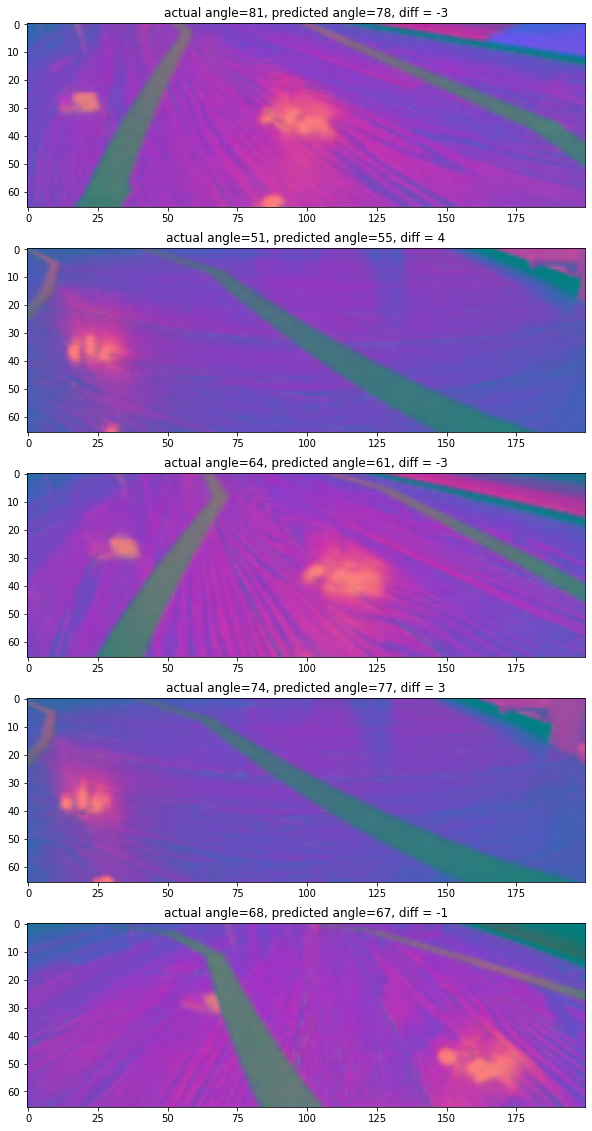

In [110]:
n_tests_show = 5
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
for i in range(n_tests_show):
    axes[i].imshow(tX_valid[i+5])
    axes[i].set_title(f"actual angle={y_valid[i]}, predicted angle={int(y_pred[i])}, diff = {int(y_pred[i])-y_valid[i]}")

## [11] 학슴모델 로딩 및 파라미터 확인하기

In [111]:
from tensorflow import keras

model_path = os.path.join(model_output_dir,'std_lane_navigation_final.h5')
print(model_path)

/content/DeepPiCar/models/lane_navigation/std_lane_navigation_final.h5


In [112]:
# keras model 로딩하기
loaded_model = keras.models.load_model(model_path)

In [113]:
#dir(loaded_model)

In [114]:
to_json = loaded_model.to_json()
print(to_json)

{"class_name": "Sequential", "config": {"name": "Nvidia_Model", "layers": [{"class_name": "Conv2D", "config": {"name": "conv2d_1", "trainable": true, "batch_input_shape": [null, 66, 200, 3], "dtype": "float32", "filters": 24, "kernel_size": [5, 5], "strides": [2, 2], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "activation": "elu", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Conv2D", "config": {"name": "conv2d_2", "trainable": true, "dtype": "float32", "filters": 36, "kernel_size": [5, 5], "strides": [2, 2], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "activation": "elu", "use_bias": true, "kernel_

In [115]:
import pprint
import json

In [116]:
pp = pprint.PrettyPrinter()
pp.pprint(json.loads(to_json))

{'backend': 'tensorflow',
 'class_name': 'Sequential',
 'config': {'build_input_shape': [None, 66, 200, 3],
            'layers': [{'class_name': 'Conv2D',
                        'config': {'activation': 'elu',
                                   'activity_regularizer': None,
                                   'batch_input_shape': [None, 66, 200, 3],
                                   'bias_constraint': None,
                                   'bias_initializer': {'class_name': 'Zeros',
                                                        'config': {}},
                                   'bias_regularizer': None,
                                   'data_format': 'channels_last',
                                   'dilation_rate': [1, 1],
                                   'dtype': 'float32',
                                   'filters': 24,
                                   'kernel_constraint': None,
                                   'kernel_initializer': {'class_name': 'VarianceS